In [1]:
from math import sqrt
import numpy as np
import pandas as pd

from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# 使用前400个点的 speed & power 预测接下来 4h(4h/15min) 的power
n_back = 24*60*2   #使用前多少个点
n_out = 12*4       #预测之后多少个  预测之后12h，则是12*4个点
n_pre = n_out*15*2
n_feature = 2
# 使用前6天的数据进行训练
train_len = 6
# 神经网络参数
units = 300
rounds = 200
size = 72

In [3]:
dataset = pd.read_csv("C:/Users/24496/Desktop/BigData/wind_preprocessed.csv", header=0, index_col=0).query('day<14')
dataset

,power,speed,date.1,day,hour,minute,second,speed_moveavg,power_moveavg,speed_savgol_filter,power_savgol_filter
date,,,,,,,,,,,
2015-10-01 00:00:00,0.38065,0.39627,2015-10-01 00:00:00,1,0,0,0,0.39627,0.38065,0.39630,0.37963
2015-10-01 00:00:30,0.36943,0.39592,2015-10-01 00:00:30,1,0,0,30,0.39592,0.36943,0.39580,0.37350
2015-10-01 00:01:00,0.38529,0.39538,2015-10-01 00:01:00,1,0,1,0,0.39538,0.38529,0.39555,0.37919
2015-10-01 00:01:30,0.38892,0.39579,2015-10-01 00:01:30,1,0,1,30,0.39579,0.38892,0.39555,0.39443
2015-10-01 00:02:00,0.41220,0.39627,2015-10-01 00:02:00,1,0,2,0,0.39627,0.41220,0.39670,0.41116
...,...,...,...,...,...,...,...,...,...,...,...
2015-10-13 23:57:30,0.19256,0.34645,2015-10-13 23:57:30,13,23,57,30,0.34645,0.19256,0.34587,0.19193
2015-10-13 23:58:00,0.19485,0.34559,2015-10-13 23:58:00,13,23,58,0,0.34559,0.19485,0.34594,0.19456
2015-10-13 23:58:30,0.19554,0.34562,2015-10-13 23:58:30,13,23,58,30,0.34562,0.19554,0.34539,0.19412


In [4]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


In [5]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [6]:
# 分割为训练集和测试集
values = reframed.values
n_train_hours = train_len*24*60*2
train = values[:n_train_hours, :]
# print(train)
test = values[n_train_hours:, :]
# 分为输入输出
n_obs = n_back * n_feature
train_X, train_y = train[:, :n_obs], train[:, -n_out:]
print('-------------------')
# print(train_X[0])
print('-------------------')
# print(train_y[0])

# print(train_X.shape[0])
test_X, test_y = test[:, :n_obs], test[:, -n_out:]
# print(train_X.shape, train_y.shape)
# print(test_X.shape, test_y.shape)
# 重塑成3D格式 [samples, timesteps, features]
print(train_X)
# print(n_back)
# print()
# train_X = train_X.reshape((train_X.shape[0], n_back, n_feature))
# print(train_X)
# test_X = test_X.reshape((test_X.shape[0], n_back, n_feature))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# train_X.shape[1]

-------------------
-------------------
[[0.39627 0.38065 0.39592 ... 0.00883 0.18304 0.00929]
 [0.39592 0.36943 0.39538 ... 0.00929 0.18371 0.00915]
 [0.39538 0.38529 0.39579 ... 0.00915 0.18257 0.00864]
 ...
 [0.26301 0.08854 0.25858 ... 0.13097 0.29348 0.14164]
 [0.25858 0.08421 0.25952 ... 0.14164 0.29257 0.13808]
 [0.25952 0.08376 0.25713 ... 0.13808 0.29284 0.13665]]


In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,LSTM


In [13]:
# 初始化顺序模型
regressor = Sequential()
 
# 定义输入层及带5个神经元的隐藏层
regressor.add(SimpleRNN(units = 8, input_shape = (train_X.shape[1], 1)))
# 定义线性的输出层
regressor.add(Dense(units = 12*4))
# 模型编译：定义优化算法adam， 目标函数均方根MSE
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# 模型训练
history = regressor.fit(train_X, train_y, epochs = 50, batch_size = 500, validation_split=0.3)

# regressor.summary()

Epoch 1/50
17/25 [===================>..........] - ETA: 5s - loss: 0.2598

KeyboardInterrupt: 

In [ ]:
# regressor.save_weights('RNN_1.h5')

In [ ]:
regressor.save_weights('RNN_4.h5')

In [10]:
# 绘制历史数据
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
# plt.title(f'Epochs={epoch_num}, Batch_size={batch_size},Ahead=400')
# plt.savefig(f'compare/{n}.png')
plt.legend()
plt.show()


NameError: name 'history' is not defined

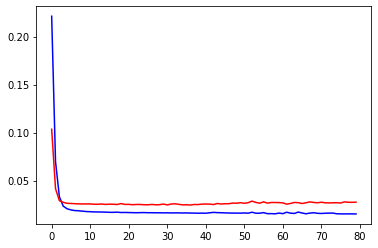

In [ ]:
plt.plot(history.history['loss'],c='blue')    # 蓝色线训练集损失
plt.plot(history.history['val_loss'],c='red') # 红色线验证集损失
plt.show()

In [ ]:
#使用第12天的数据做预测验证
df_test = data.iloc[1*2880:2*2880]
df_test
# df_test.isnull().values.any()

,speed,power
date,,
2015-10-02 00:00:00,0.18371,0.00915
2015-10-02 00:00:30,0.18257,0.00864
2015-10-02 00:01:00,0.18162,0.00627
2015-10-02 00:01:30,0.18062,0.00664
2015-10-02 00:02:00,0.17980,0.00648
...,...,...
2015-10-02 23:57:30,0.33787,0.22594
2015-10-02 23:58:00,0.33951,0.22907
2015-10-02 23:58:30,0.33987,0.23524


In [ ]:
df_test_only_power = df_test[['power','speed']]
df_test_only_power

,power,speed
date,,
2015-10-02 00:00:00,0.00915,0.18371
2015-10-02 00:00:30,0.00864,0.18257
2015-10-02 00:01:00,0.00627,0.18162
2015-10-02 00:01:30,0.00664,0.18062
2015-10-02 00:02:00,0.00648,0.17980
...,...,...
2015-10-02 23:57:30,0.22594,0.33787
2015-10-02 23:58:00,0.22907,0.33951
2015-10-02 23:58:30,0.23524,0.33987


In [ ]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [ ]:
# 分割为训练集和测试集
values = reframed.values
# n_train_hours = train_len*24*60*2
# train = values
# print(train)
# test = values[n_train_hours:, :]
# 分为输入输出
n_obs = n_back * n_feature
real_X, real_y = values[:, :n_obs], train[:, -n_out:]
# print('-------------------')
# # print(train_X[0])
# print('-------------------')
# # print(train_y[0])

# # print(train_X.shape[0])
# # test_X, test_y = test[:, :n_obs], test[:, -n_out:]
# # print(train_X.shape, train_y.shape)
# # print(test_X.shape, test_y.shape)
# # 重塑成3D格式 [samples, timesteps, features]
# print(train_X)
# print(n_back)
# print()
# train_X = train_X.reshape((train_X.shape[0], n_back, n_feature))
# print(train_X)
# test_X = test_X.reshape((test_X.shape[0], n_back, n_feature))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# train_X.shape[1]

In [ ]:
y_test_predict=regressor.predict(real_X)
#模型评估
# print('预测与实际差异MSE:',(sum(pow((y_test_predict - real_y),2))/y_test_predict.shape[0])**0.5)



1144/1144 [==============================] - 25s 22ms/step


In [ ]:
#模型评估
# print('预测与实际差异RMSE:',(sum(pow((y_test_predict - train_y),2))/y_test_predict.shape[0])**0.5)

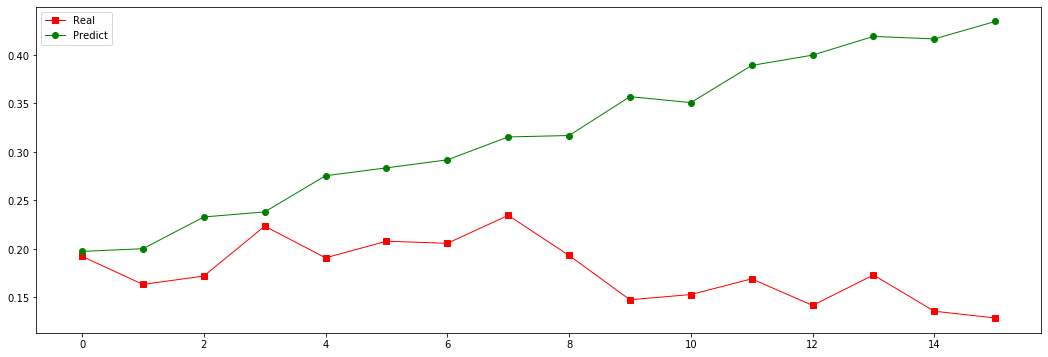

In [ ]:
t = np.arange(len(y_test_predict[4]))
plt.figure(figsize=(18,6))
plt.plot(t, train_y[40],"rs-", linewidth=1, label='Real')
plt.plot(t, y_test_predict[40], 'go-', linewidth=1, label='Predict')
plt.legend()
plt.show()


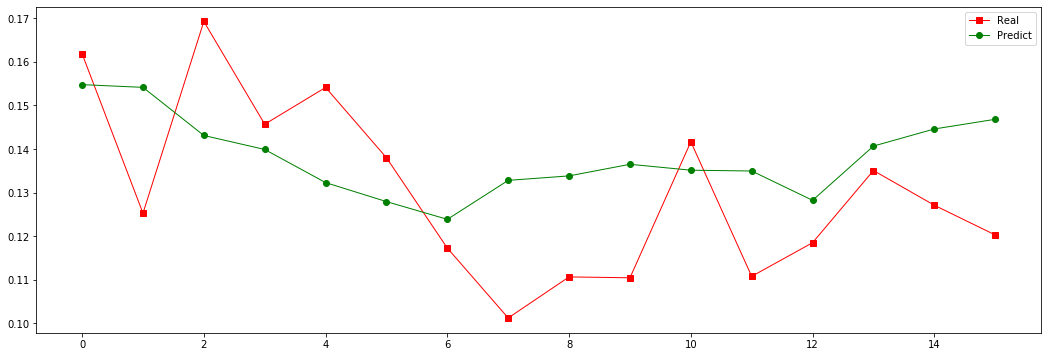

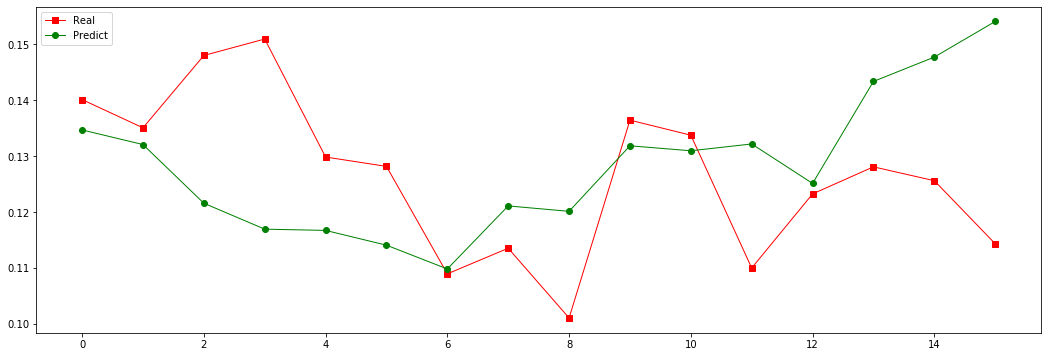

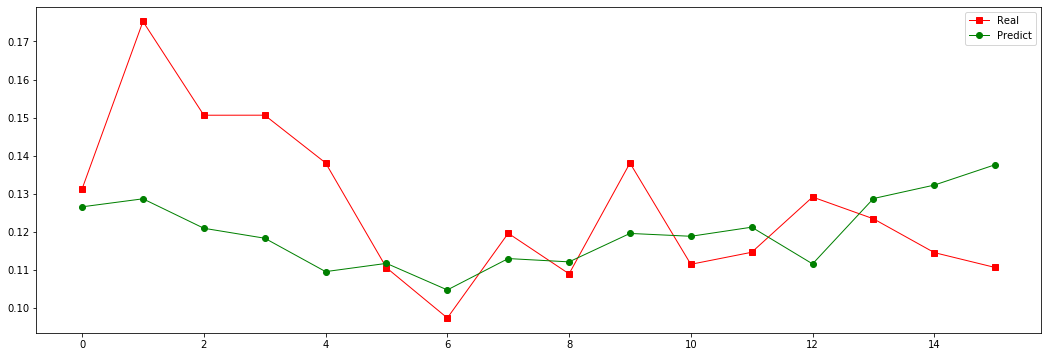

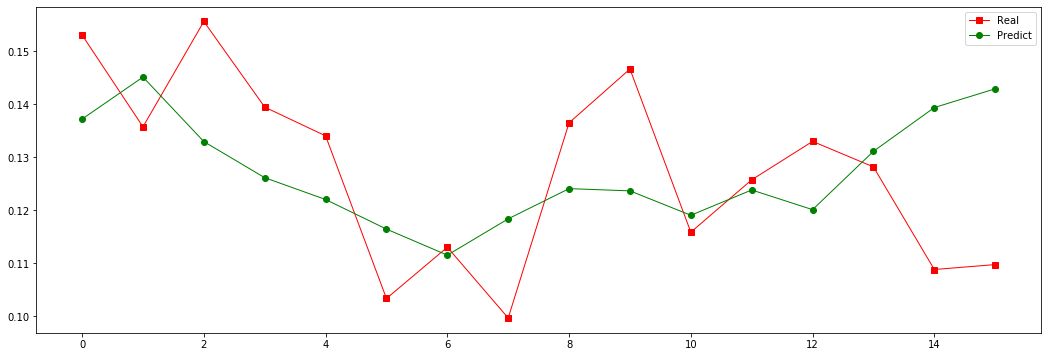

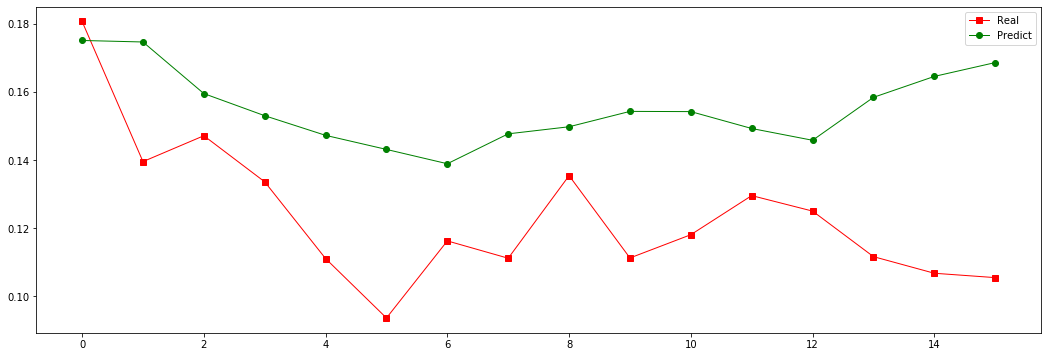

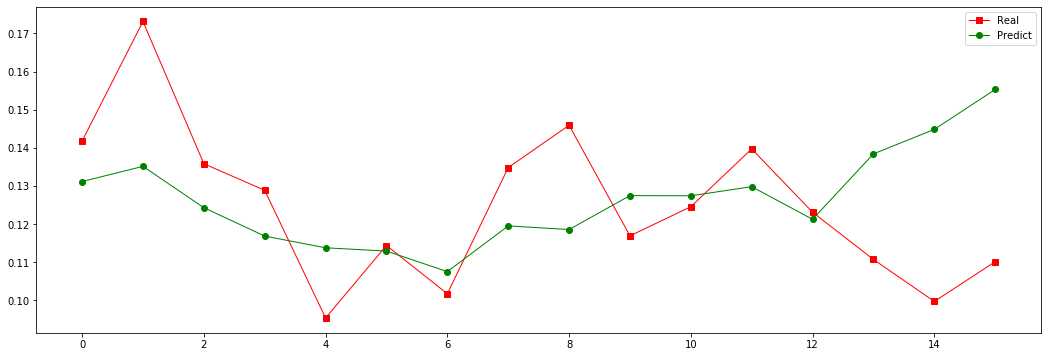

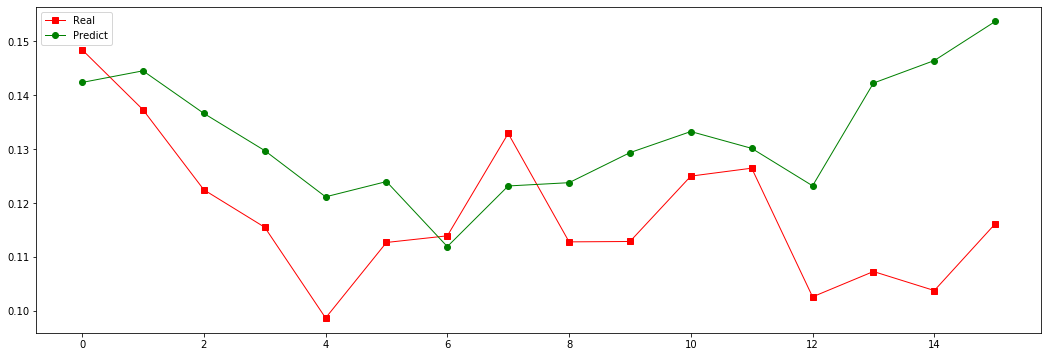

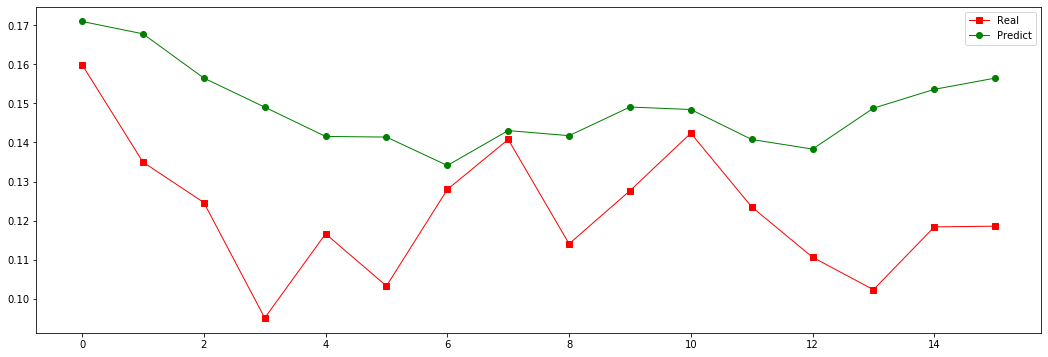

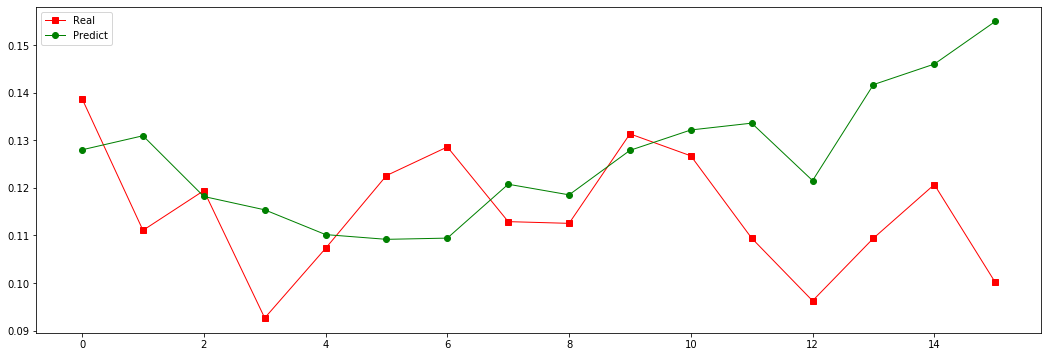

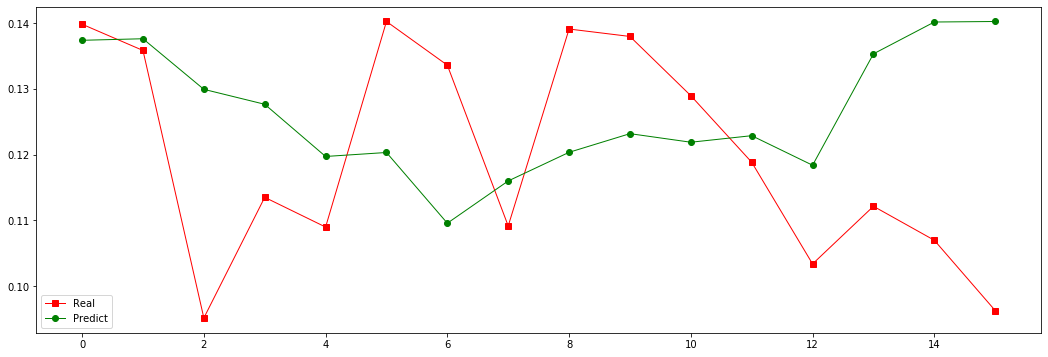

In [ ]:
for i in range(20,30):
    t = np.arange(len(y_test_predict[i*16]))
    plt.figure(figsize=(18,6))
    plt.plot(t, real_y[i*16],"rs-", linewidth=1, label='Real')
    plt.plot(t, y_test_predict[i*16], 'go-', linewidth=1, label='Predict')
    plt.legend()
    plt.show()